In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    %matplotlib widget
    figsize=(9, 3)
else:
    figsize=(14, 4)


from util import util
import numpy as np

# Generate ground truth data
V0, tau, Vs, tmax = 0, 8, 12, 60
data = util.simulate_RC(V0, tau, Vs, tmax, steps_per_unit=1)

# Better Learning for ODEs

## Decomposing Sequences

**We can address the first two issues using a _reformulation_**

Let's consider the sequence of measurements $\{\hat{y}_k \}_{k=0}^n$

* We can view it as a sequence of _pairs $\{(\hat{y}_{-1}, \hat{y}_{k}\}_{k=1}^n$_
* ...Each referring to a _distinct_ ODE, i.e. $\dot{y}_k = f(y_k, t, \omega)$
* ...With all ODEs sharing the _same_ parameter vector $\omega$

**With this approach, we can reformulate the training problem as:**

$$\begin{align}
\text{argmin}_\omega \ & \sum_{k=1}^n L(y_k(\hat{t}_k), \hat{y}_k) \\
\text{subject to: } & \dot{y}_k = f(y_k, t, \omega) & \forall k = 1..n\\
& y_k(\hat{t}_{k-1}) = \hat{y}_{k-1} & \forall k = 1..n
\end{align}$$

* In practice, we assume we are dealing with _multiple initial value problems_

## Decomposing Sequences

**Let's examine again the new training problem:**

$$\begin{align}
\text{argmin}_\omega \ & \sum_{k=1}^n L(y_k(\hat{t}_k), \hat{y}_k) \\
\text{subject to: } & \dot{y}_k = f(y_k, t, \omega) & \forall k = 1..n\\
& y_k(\hat{t}_{k-1}) = \hat{y}_{k-1} & \forall k = 1..n
\end{align}$$

There a few things to keep in mind:

* The approach is viable only if we have measurements for the _full state_
* ...And we are also assuming that the original loss is _separable_
* Finally, the new training problem is _not exactly equivalent_ to the old one
* ...Since by re-starting at each step we are disregarding compound errors

## Preparing the Data

**Our implementation can naturally deal with the reformulation**

We just need to properly prepare the data

* Each ODE can be seen as a different _example_

In [2]:
ns = len(data.index)-1

* The sequence for each example contains _only two_ measurements
* ...Corresponding to consecutive evaluation points

In [3]:
tr_T = np.vstack((data.index[:-1], data.index[1:])).T
print(tr_T[:3])

[[0. 1.]
 [1. 2.]
 [2. 3.]]


## Preparing the Data

**Our implementation can naturally deal with the reformulation**

We just need to properly prepare the data

* The first measurement represents the initial state

In [4]:
tr_y0 = np.array(data.iloc[:-1]).reshape(-1, 1)
print(tr_y0[:2])

[[0.        ]
 [1.41003718]]


* The second to the final state, which we need for defining a target tensor

In [6]:
tr_y = np.full((ns, 2, 1), np.nan)
tr_y[:, 1, :] = data.iloc[1:]
print(tr_y[:2])

[[[       nan]
  [1.41003718]]

 [[       nan]
  [2.6543906 ]]]


## Training

**Then we can perform training as usual**

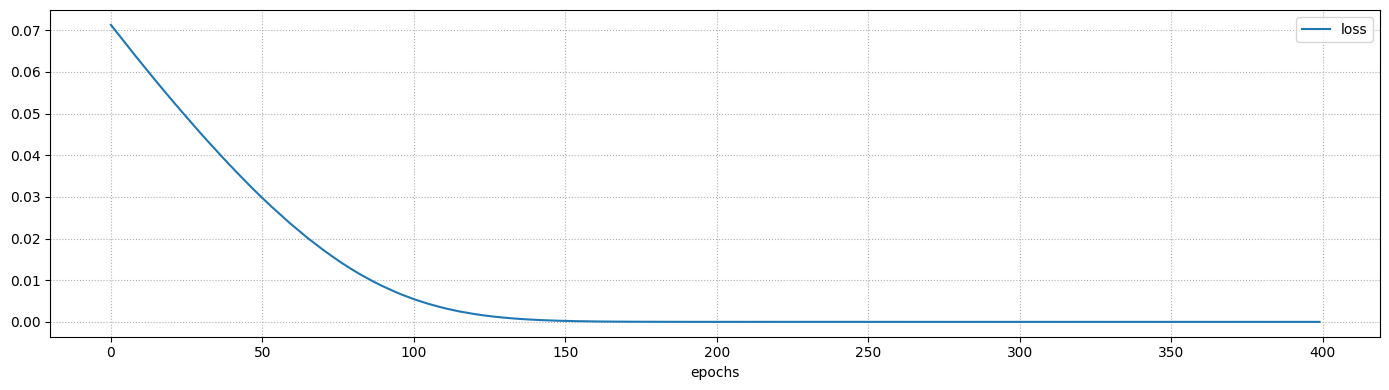

Final loss: 0.0000 (training)
CPU times: user 1.48 s, sys: 308 ms, total: 1.79 s
Wall time: 1.26 s


In [8]:
%%time
dRC = util.RCNablaLayer(tau_ref=10, vs_ref=10)
euler = util.ODEEulerModel(dRC)
history = util.train_nn_model(euler, [tr_y0, tr_T], tr_y, loss='mse', validation_split=0.0, epochs=400)
util.plot_training_history(history, figsize=figsize)

## Training

**The results are the same as before (including estimation problems)**

In [9]:
print(f'tau: {tau:.2f} (real), {dRC.get_tau().numpy()[0]:.2f} (estimated)')
print(f'Vs: {Vs:.2f} (real), {dRC.get_vs().numpy()[0]:.2f} (estimated)')

tau: 8.00 (real), 8.51 (estimated)
Vs: 12.00 (real), 12.00 (estimated)


**...But there are significant computational advantages**

Since we are using a _shallow_ compute graph rather than a deep one...

* The training time is much lower
* Potential vanishing/exploding gradient problems are absent

Since we now have _multiple examples_...

* We can benefit from stochastic gradient descent
* We can use a validation set

## Training

**Just keep in mind that using a validation set will slow down the process**

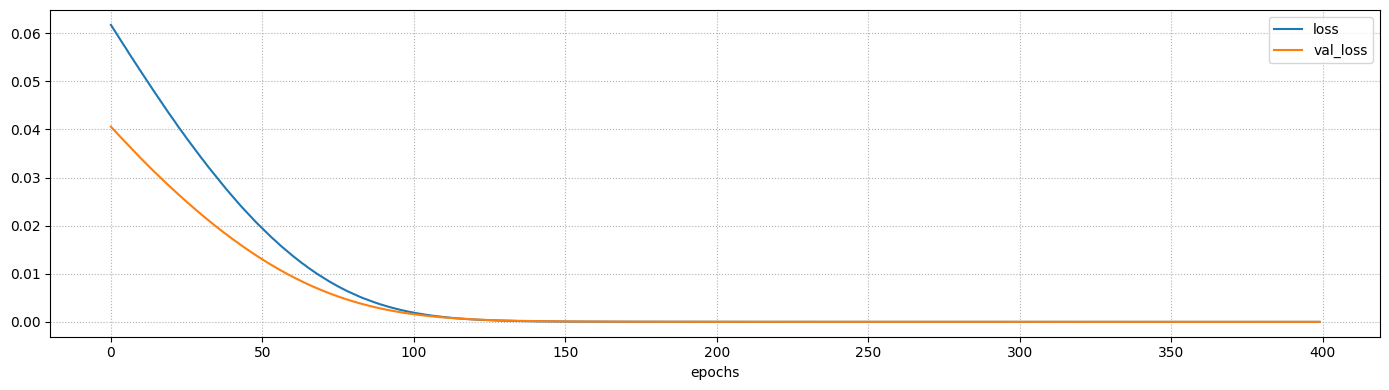

Final loss: 0.0000 (training), 0.0000 (validation)
CPU times: user 7.02 s, sys: 624 ms, total: 7.65 s
Wall time: 6.69 s


In [10]:
%%time
dRC = util.RCNablaLayer(tau_ref=10, vs_ref=10)
euler = util.ODEEulerModel(dRC)
history = util.train_nn_model(euler, [tr_y0, tr_T], tr_y, loss='mse', validation_split=0.2, epochs=400, patience=10)
util.plot_training_history(history, figsize=figsize)

## Accuracy Issues

**We are now ready to tackle our _estimation issues_**

* We know we have trouble _estimating the $\tau$ parameter_
* Intuitively, that should translate in trouble _estimating the dynamic behavior_

**Let's try to replicate integration using our model**

* We prepare data structures to replicate our original run

In [12]:
run_y0 = data.iloc[0].values.reshape(1, -1)
run_T = np.array([data.index])
print('y0:', run_y0)
print('T:', run_T)

y0: [[0.]]
T: [[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
  18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
  36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
  54. 55. 56. 57. 58. 59. 60.]]


## Accuracy Issues

**Then we can run Euler method directly using our model**

As a side benefit, this will naturally use the estimate parameters

In [14]:
run_y = euler.predict([run_y0, run_T], verbose=0)

Next, let's build a dataset with the original data and the predictions:

In [15]:
data_euler = data.copy()
data_euler['euler'] = run_y[0]
data_euler.head()

,V,euler
time,,
0.0,0.000000,0.000000
1.0,1.410037,1.410401
2.0,2.654391,2.655018
3.0,3.752529,3.753339
4.0,4.721632,4.722559


## Accuracy Issues

**Finally, we can plot the two curves**

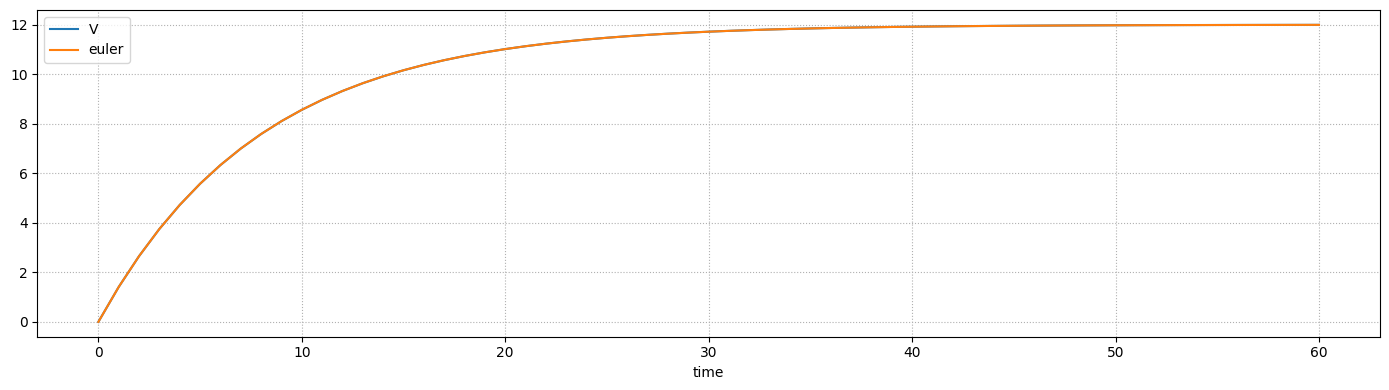

In [16]:
util.plot_df_cols(data_euler, figsize=figsize)

We have a very good match!

> **What is going on?**

## Accuracy Issues?

**We formulated the training problem in terms of curve fitting**

* I.e. we optimized $\tau$ and $V_s$ so as to obtain a close fitting curve
* ...Constructed using Euler method

**The problem is that Euler method is _inaccurate_**

* If using _wrong parameters_ will lead to a _better fitting_ curve
* ...Our approach will not hesitate to do just that

**Is this a problem?**

If we just care about _the curve, not at all_

* It can actually be an advantage, if properly exploited

If we care about estimating _parameters, then yes_

* ...But it also suggests an easy fix (using a more accurate integration method)

## Improving Parameter Estimation

**For sake of simplicity, we will keep using Euler method**

...And we will just increase the number of steps to improve its accuracy

* First, we introduce _more evaluation points_ for each measurement pair

In [19]:
nsteps = 11
tr_T2 = np.vstack(np.linspace(data.index[:-1], data.index[1:], nsteps)).T
print(tr_T2[:2])

[[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
 [1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2. ]]


* Second, we update the target sequences to match the size

In [20]:
tr_y2 = np.full((ns, nsteps, 1), np.nan)
tr_y2[:, -1, :] = data.iloc[1:]
print(str(tr_y2[:2]).replace('\n', ', ').replace(' ', '').replace(',,', '\n'))

[[[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[1.41003718]]
[[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[2.6543906]]]


## Improving Parameter Estimation

**Then, we can train as usual**

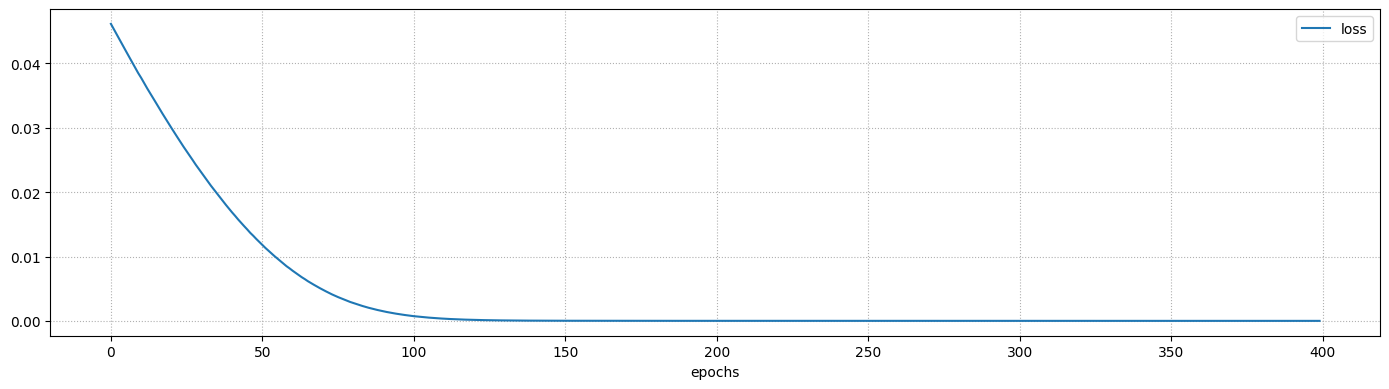

Final loss: 0.0000 (training)
CPU times: user 2.36 s, sys: 266 ms, total: 2.63 s
Wall time: 1.99 s


In [21]:
%%time
dRC2 = util.RCNablaLayer(tau_ref=10, vs_ref=10)
euler2 = util.ODEEulerModel(dRC2)
history = util.train_nn_model(euler2, [tr_y0, tr_T2], tr_y2, loss='mse', validation_split=0.0, epochs=400)
util.plot_training_history(history, figsize=figsize)

## Improving Parameter Estimation

**This approach leads to considerably better estimates**

In [22]:
print(f'tau: {tau:.2f} (real), {dRC2.get_tau().numpy()[0]:.2f} (estimated)')
print(f'Vs: {Vs:.2f} (real), {dRC2.get_vs().numpy()[0]:.2f} (estimated)')

tau: 8.00 (real), 8.05 (estimated)
Vs: 12.00 (real), 12.00 (estimated)


* The results can be improved by using additional steps
* ...Or by switching to a different method (e.g. RK4, adjoint state...)

**Overall, when using this appraoch...**

...It's important to be aware that integration methods are _approximate_

* This can easily lead to incorrectly estimated parameters
* Which may or may not be a problem, depending on your priorities